In [18]:
import pandas as pd
from glob import glob
import numpy as np
import json
import os.path as osp
import sys
%run /home/grg/git/alfa/nilearn-helper.py
%matplotlib inline
sys.path.append('/home/grg/git/pyAAL')
import pyAAL

/home/grg/jupyter/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
groups_names = ['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44']
spmdir = '/home/grg/spm/'
subjects = json.load(open(osp.join(spmdir, 'data', 'subjects.json')))

In [68]:
def getdict(data, key, column, column2=None, value=None):
    import string
    if not value is None:
        data = data[data[column2] == value]
        
    d1 = dict([(string.atoi(str(int(e))), v) for e, v in data[[key, column]].to_dict(orient='split')['data']])
    return d1

fsvol_fp = osp.join(spmdir, 'data', 'aseg FS ALFA.xlsx')
vvol = pd.read_excel(fsvol_fp)    
d = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Right-Lateral-Ventricle')

In [69]:
# From AAL V4, load labels - names translation table
labels_fp = '/home/grg/data/templates/MNI_atlas_templates/aal_MNI_V4.txt'
df = pd.read_csv(labels_fp, sep='\t', skiprows=0)
labels = {}
for i in range(1,117):
    labels[i] = json.loads(df.to_json()).items()[0][1][str(i)]

roiname = 'Hippocampus_L'
roilabel = [k for k,v in labels.items() if v == roiname][0]
print roiname, roilabel

def collect_data(verbose=False):
    
    # Loading json data etc..
    spmdir = '/home/grg/spm/'
    subjects = json.load(open(osp.join(spmdir, 'data', 'subjects.json')))
    print len(subjects)

    # Reading main tables with metadata
    demo_fp = osp.join(spmdir, 'data', 'Data_VBM_Alfa.csv')
    subj_fp= osp.join(spmdir, 'data', 'subjects.json')
    gend_fp= osp.join(spmdir, 'data', 'genders.json')
    educ_fp = osp.join(spmdir, 'data', 'educyears.json')
    tiv_fp = osp.join(spmdir, 'data', 'tiv.json')
    fsvol_fp = osp.join(spmdir, 'data', 'aseg FS ALFA.xlsx')
    ages_fp = osp.join(spmdir, 'data', 'age.json') # contains ages in days

    demo = pd.read_csv(demo_fp)
    subjects = json.load(open(subj_fp))
    groups_size = [102, 44, 143, 160, 65]
    assert(sum(groups_size) == len(subjects))

    # Sorting out groups
    groups = []
    start = 0
    for size in groups_size:
        g = subjects[start:start + size]
        start = start + size
        groups.append(g)

    ages = json.load(open(ages_fp))
    genders = json.load(open(gend_fp))
    educyears = json.load(open(educ_fp))
    tivs = json.load(open(tiv_fp))
    vvol = pd.read_excel(fsvol_fp)    
    
    # FreeSurfer Volumes
    vvol_l = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Left-Lateral-Ventricle')
    vvol_r = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Right-Lateral-Ventricle')
    vvol_li = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','Left-Inf-Lat-Vent')
    vvol_ri = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','Right-Inf-Lat-Vent')
    vvol_3 = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','3rd-Ventricle')
    vvol_4 = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', '4th-Ventricle')    
    
    # Building dataframe
    data = []
    subj = []
    for s in subjects:    
        if verbose: print s
        group = [int(s in each) for each in groups]
        group_nb = group.index(1)
        row = []
        try:
            fsvol_l = (vvol_l[s] + vvol_li[s]) / tivs[str(s)]
            fsvol_r = (vvol_r[s] + vvol_ri[s]) / tivs[str(s)]
            fsvol = fsvol_l + fsvol_r
            age = ages[str(s)]
            row.append(group_nb)
            row.extend([age, genders[str(s)], educyears[str(s)], fsvol])            
            subj.append(s)
            data.append(row)
        except KeyError as e:
            print e
        except IndexError as e:
            print e
            print 'removed', s
            
    columns=['apo', 'age', 'gender', 'educyears', 'ventricles']
    return pd.DataFrame(data, index=subj, columns=columns)

data = collect_data()
data.to_excel('/home/grg/spm/data/covariates.xls')

Hippocampus_L 37


In [59]:
def collect_roivalues(roilabel, verbose=False):
    ''' This collect the values from *_AAL_MD_stats.csv files, that is 
    MD mean values in every subject's NATIVE space.
    '''
    
    subjects  = json.load(open('/home/grg/spm/data/subjects.json'))
    data_wd = '/home/grg/data/ALFA_DWI'
    
    data = []
    subj = []
    
    for s in subjects:    
        fp = glob(osp.join(data_wd, '%s*/DWI/%s*_AAL_MD_stats.csv'%(s,s)))[0]
        if verbose:
            print s, fp
        df = pd.read_csv(fp, sep='\t').set_index('ROI_label')   
        try:
            data.append(df.ix[roilabel]['mean'])            
            subj.append(s)            
        except KeyError as e:
            print 'KeyError: skipped subject', s, 'label', e
        except IndexError as e:
            print 'IndexError: skipped subject', s, 'label', e
    return pd.DataFrame(data, index=subj, columns=['roi'])

In [60]:
data = pd.read_excel('/home/grg/spm/data/covariates.xls')
roilabel = 37
roivalues = collect_roivalues(roilabel)
df = pd.concat([data, roivalues], axis=1)
df['subject'] = df.index
df = df.sort_values(['apo', 'subject']).dropna()
df.head()

514
KeyError: skipped subject 21057 label 38
KeyError: skipped subject 66133 label 38
KeyError: skipped subject 10333 label 38
IndexError: skipped subject 10657 label index 38 is out of bounds for axis 0 with size 0
KeyError: skipped subject 21056 label 38
IndexError: skipped subject 10701 label index 38 is out of bounds for axis 0 with size 0
KeyError: skipped subject 77047 label 38


,apo,age,agesq,gender,educyears,ventricles,roi,subject
10070,0,18548,344028304,0,10,4.520876,0.001197,10070
10102,0,23400,547560000,1,18,16.507219,0.001520,10102
10108,0,21434,459416356,0,15,10.421616,0.001331,10108
10235,0,22370,500416900,0,8,7.564201,0.001358,10235
10365,0,17795,316662025,0,12,7.770477,0.001255,10365


In [300]:
y_name = 'mean'
x_name = ['apo', 'age', 'gender', 'educyears', 'ventricles']
#test_scores = sm.OLS(np.asarray(df[y_name]), np.asarray(df[x_name])).fit()
model = 'mean ~ 1 + C(apo) + age + gender + educyears + ventricles'
test_scores = ols(model, data=df).fit()

In [55]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def set_figaxes(df):
    plt.xlabel('age')
    plt.ylabel('roi')
    plt.ylim([0.001, df['roi'].max()])
    plt.xlim([df['age'].min(), df['age'].max()])
    return fig

def plot_region(roiname, dataset, order=1, ax=None):
    if ax == None:
        fig = plt.figure(figsize=(6, 6))
        set_figaxes(dataset)
        ax = fig.add_subplot(111)

    colors = ['b','r','g','m','y']
    formulas = ['roi ~ 1 + age', 
                'roi ~ 1 + age + I(age**2)', 
                'roi ~ 1 + age + I(age**2) + I(age**3)']
    print 'Region:', roiname, '- Fitting order:', order, '- Formula:', formulas[order-1]
    
    # take each group separately    
    for i in xrange(5):
        df = dataset[dataset['apo'] == i]
        ax.scatter(df['age'], df['roi'], edgecolors=colors[i], facecolors='none', 
                   label='%s'%groups_names[i].capitalize(), s=10, alpha=0.7)
        x = pd.DataFrame({'age': np.linspace(df['age'].min(), df['age'].max(), 100)})
        
        poly = ols(formula=formulas[order-1], data=df).fit()
        ypred = poly.predict(x)
        ax.plot(x['age'], ypred, colors[i]+'-', 
                label='%s Poly n=%s $R^2$=%.2f $AIC$=%.2f' % (groups_names[i].capitalize(), order, poly.rsquared, poly.aic), 
                alpha=1.0)

    ax.legend(prop={'size':6})
    ax.text(0.15, 0.95, roiname, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    plt.title(roiname)


In [ ]:
def plot_regions(data, regions, nb_orders=3):
    nb_regions = len(regions)
    fig = plt.figure(figsize=(6*nb_orders, 6*nb_regions), dpi=300)

    for i, roilabel in enumerate(regions):
        # 1-st order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 1)
        roivalues = collect_roivalues(roilabel)
        df = pd.concat([data, roivalues], axis=1)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
        set_figaxes(df)
        roiname = labels[roilabel]
        plot_region(roiname, df, order=1, ax=ax)

        # 2-nd order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 2)
        roivalues = collect_roivalues(roilabel)
        df = pd.concat([data, roivalues], axis=1)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
        set_figaxes(df)
        roiname = labels[roilabel]    
        plot_region(roiname, df, order=2, ax=ax)

        # 3-rd order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 3)
        roivalues = collect_roivalues(roilabel)
        df = pd.concat([data, roivalues], axis=1)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
        set_figaxes(df)
        roiname = labels[roilabel]
        plot_region(roiname, df, order=3, ax=ax)
 

This collect the values from \*\_AAL_MD_stats.csv files, i.e. MD mean values in every subject's NATIVE space.
The bad thing with this is that the ROI do not exclusively focus on our significant clusters measuring differences between apoE groups. So, mean values in these regions will dilute signal from these clusters with signal from outside.

KeyError: skipped subject 10576 label 71
KeyError: skipped subject 21057 label 71
KeyError: skipped subject 66133 label 71
KeyError: skipped subject 10333 label 71
IndexError: skipped subject 10657 label index 71 is out of bounds for axis 0 with size 0
KeyError: skipped subject 21056 label 71
IndexError: skipped subject 10701 label index 71 is out of bounds for axis 0 with size 0
KeyError: skipped subject 77047 label 71
Region: Caudate_L - Fitting order: 1 - Formula: roi ~ 1 + age
KeyError: skipped subject 10576 label 71
KeyError: skipped subject 21057 label 71
KeyError: skipped subject 66133 label 71
KeyError: skipped subject 10333 label 71
IndexError: skipped subject 10657 label index 71 is out of bounds for axis 0 with size 0
KeyError: skipped subject 21056 label 71
IndexError: skipped subject 10701 label index 71 is out of bounds for axis 0 with size 0
KeyError: skipped subject 77047 label 71
Region: Caudate_L - Fitting order: 2 - Formula: roi ~ 1 + age + I(age**2)
KeyError: skippe

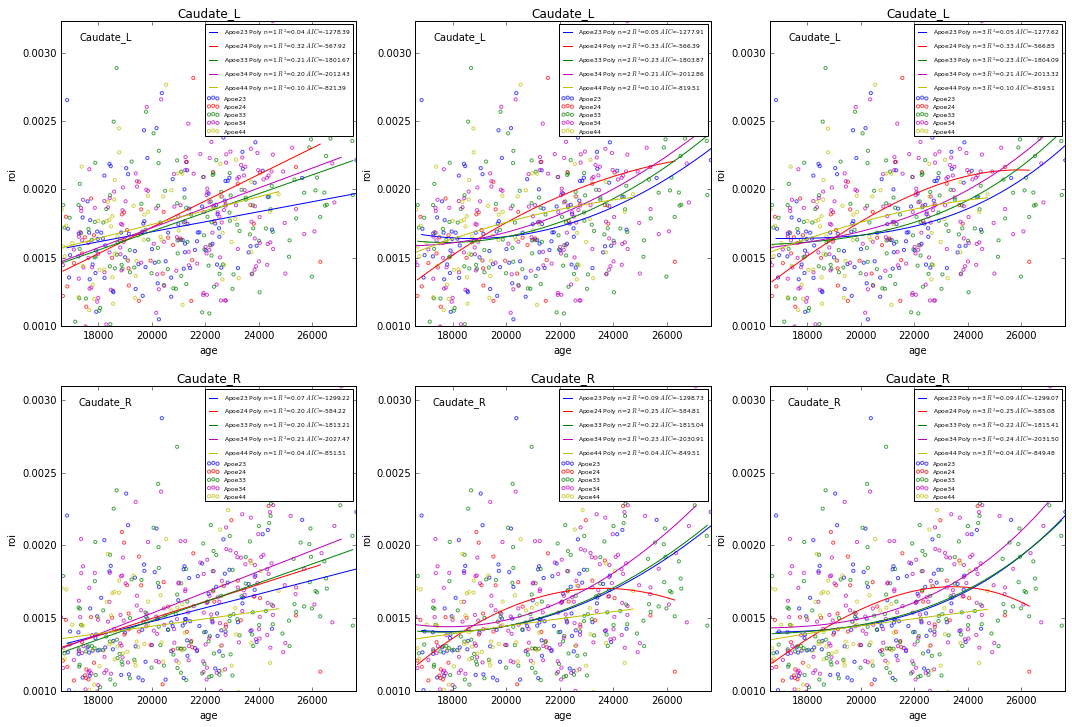

In [67]:
       
regions = [37,38,27,28]
#plot_regions(data, regions)

plot_regions(data, [71,72])

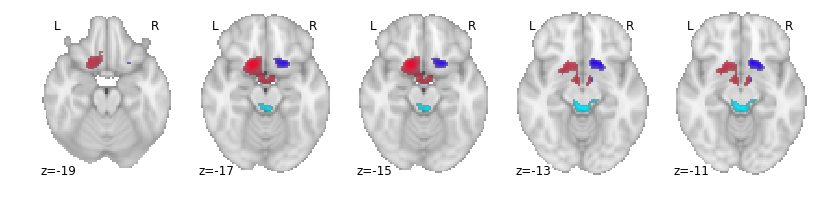

In [349]:
from nilearn import regions
reg, _ = regions.connected_regions('/tmp/thresholded_spmT.nii.gz', min_region_size=50)
plotting.plot_prob_atlas(reg, display_mode='z', cut_coords=range(-19,-10,2))
reg.to_filename('/tmp/regions.nii.gz')